<a href="https://colab.research.google.com/github/m7saikat/IE-7374/blob/master/Lab_2(a)_MABs_Binomial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2-a: Multi-armed Bandits Problem (Binomial)

---
 




### 1- Problem definition : k-armed bandits

Consider the following learning problem. You are faced repeatedly with a choice among k diﬀerent options, or actions. After each choice you receive a numerical reward chosen from a stationary probability distribution that depends on the action you selected. Your objective is to maximize the expected total reward over some time period, for example, over 1000 action selections, or time steps.

In our k-armed bandit problem, each of the $k$ actions has an expected or mean reward given that that action is selected; let us call this the value of that action. We denote the action selected on time step $t$ as $A_t$, and the corresponding reward as $R_t$. The value then of an arbitrary action $a$, denoted $q_{∗}(a)$, is the expected reward given that a is selected: 


$q_{*}(a) = \mathbb E[R_{t}|A_{t}=a] $

Knowing the value of each action would be trivial to solve the k-armed bandit problem: we would always select the action with highest value. Let us assume that we do not know the action values with certainty, although we may have estimates. We denote the estimated value of action a at time step $t$ as $Q_{t}(a)$. We would like $Q_t(a)$ to be close to $q_∗(a)$. 

At any time step there is at least one action whose estimated value is greatest,we call these the greedy actions. When one of these actions is selected, we are exploiting our current knowledge of the values of the actions. If instead we select one of the nongreedy actions, then we are exploring, because this improves the estimate of the nongreedy action’s value.



 Greedy action selection always exploits current knowledge to maximize immediate reward; it spends no time at all sampling apparently inferior actions to see if they might really be better. A simple alternative is to behave greedily most of the time, but every once in a while, say with small probability ε, instead select randomly from among all the actions with equal probability, independently of the action-value estimates. We call methods using this near-greedy action selection rule ε-greedy methods.

The simplest way to select one of the actions with the highest estimated value is selecting one of the greedy actions. If there is more than one greedy action, then a selection is made among them in some arbitrary way, perhaps randomly. We write this greedy action selection method as

$A_t \dot=  argmax_{a} Q_t(a)$

where $argmax_a$ denotes the action a for which the expression that follows is maximized (again, with ties broken arbitrarily).

In this lab, we would be simuating the k-arm bandit problem with `stationary rewards`. That is the rewards not changing over time.

### 2- Implementaiton of the 10-arm testbed

---
To roughly assess the relative eﬀectiveness of the greedy and ε-greedy methods, we compared them numerically on a suite of test problems. 

This is a set of $2000$ randomly generated k-armed bandit problems with $k = 10$. For each bandit problem the action values, $q∗(a)$, $a = 1,...,10,$ is selected according to a normal (Gaussian) distribution with mean $0$ and variance $1$. Then, when a learning method applied to that problem selected action $A_t$ at time step $t$, the actual reward, $R_t$, is selected from a normal distribution with mean $q_∗(A_t)$ and variance $1$. We call this suite of test tasks the 10-armed testbed. 

### Importing Libraries


---


Numpy - Provides us ready made fucntion to generate random gaussian distribution, get mean of a list, etc.

Matplotlib - Helps to genrate grpahs and figures.

In [0]:
import numpy as np
import matplotlib.pyplot as plt

### Calculting and displaying true rewards values: `Stationary Distribution`

---
In this section we have tried to demonstrate the reward distribution of an example bandit problem from the 10-armed testbed, for stationary rewards. Here we have generated and displayed the 10 different sample true rewards of the bandit problem, corresponding to each arm.

In [0]:
# Initial Paramteres
arms=10

In [0]:
# Mean Reward of Arms
rs = np.random.RandomState(seed=100)

# Generating 10 action values corresponding to each arm
expected_action_value = rs.uniform(0, 1, arms)
print (expected_action_value)

[ 0.54340494  0.27836939  0.42451759  0.84477613  0.00471886  0.12156912
  0.67074908  0.82585276  0.13670659  0.57509333]


### Plotting the rewards
Here we are using `matplotlib` to plot the rewards corresponding to the 10 arms.

Text(0,0.5,'Expected Action Values')

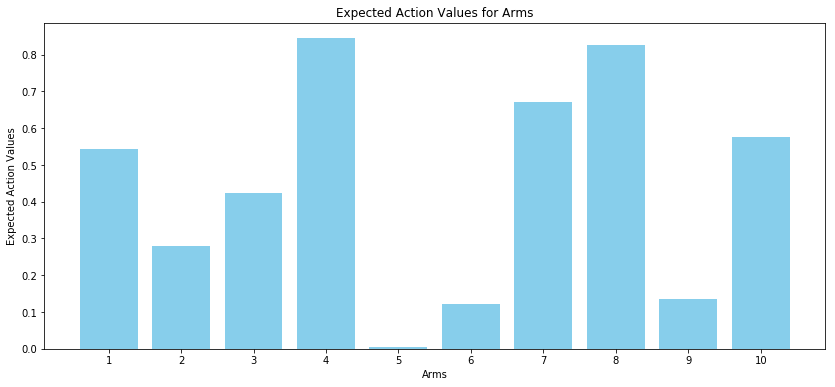

In [0]:
# Genrating the objects corresponding to the figure and the axis of the image shown below.
f, ax = plt.subplots(figsize=(14, 6))

# Generating the labels corresponding to each arm of the bandit
# Using xticks we can get or set the current tick locations and labels of the x-axis.
x_pos = range(1,arms+1)
plt.xticks(x_pos, x_pos)

# Generating the bar plot, the rewards corresponding to the 10 arms of the andit test bed as shown below
ax.bar(x_pos, expected_action_value, align='center',color='skyblue')

# Set the axis, title and the labels for the axis.
ax.set_title("Expected Action Values for Arms")
ax.set_xlabel("Arms")
ax.set_ylabel("Expected Action Values")

### Reward function

---

Given an action taken, this method randomly return $-1$ or $0$ as the reward corresponding to that action.

In [0]:
def reward_function(action_taken, expected_action_value):
    if (np.random.uniform(0, 1) <= expected_action_value[action_taken]):
        return 1
    else:
        return 0

### Methods 1:  <span style="color:blue">$\epsilon-greedy$</span>  function 

---
Given a epsilon value ($e$), this function determines whether the algorithm should go for `exploitation` or `exploration`. 

If $e$ is greater than a randomly generated value, it chooses exploration, else it chooses exploitation.

In [0]:
# Define the e-greedy funtion
def e_greedy(estimate_action_value,e,arms): 
    # genereate a random num (0,1) to be compared with epsilon
    e_estimator = np.random.uniform(0, 1) 
    # epsilon-greedy appraoch
    action = np.argmax(estimate_action_value) if e_estimator > e else np.random.choice(np.arange(arms))
    return action

### Action Value estimation, Method 1 -  <span style="color:blue">Sample Average approach</span> 
---
Given an action, number of times the action is taken, this function estimates the action value. 

To simplify notation, we concentrate on a single action. Let $R_i$  denote the reward received after the $i$th selection of this action, and let $Q_n$ denote the estimate of its action value after it has been selected $n−1$ times, which we can now write simply as

$Q_n \dot= \frac{R_1+R_2+R_3+...+R_{n-1}}{n-1}$

This equation mentioned above can be refactored as follows

$Q_{n+1} = Q_n + \frac{1}{n} [R_n - Q_n ]$ ... (2.3)
**bold text**
That is,

$NewEstimate \leftarrow OldEstimate + StepSize[Target - OldEstimate]$

This function replicates the equation (2.3) mentioned above.


In [0]:
# Define estimate_action_value function (using sample average method)
def sample_average (estimate_action_value, action, reward, count):
    estimate_action_value[action] = estimate_action_value[action] + (1/(count[action]+1))\
        * (reward - estimate_action_value[action])
    return estimate_action_value

### The k-armed bandits function

---

This function simulates the k-armed bandits problem base don the given inputs, including the  `number of arms`, `number of steps`, `epsilon`, and `expected action values`. Then, the function runs the problem for 'number of steps' times and returns the the `overall reward` and `optimal action`corresponding to each step.

The function uses `sample average` to update for stationary reward estimation.

In [0]:
def multi_arm_bandit_problem(arms = 10, steps = 1000, e = 0.1, expected_action_value = [] ):
    # Initilization 
    overall_reward, optimal_action = [], [] 
    estimate_action_value = np.zeros(arms) # Initial estimate of action values is set to zero 
    count = np.zeros(arms) #number of times the action (arm) is taken

    # Main loop
    for s in range(0, steps):

        # Select an action
        action=e_greedy(estimate_action_value,e, arms)

        # Observe the reward for the selected Action
        reward = reward_function(action, expected_action_value)

        # Update Estimates of Action Value for the selected Action based on its observed Reward
        estimate_action_value=sample_average(estimate_action_value, action, reward, count)
        
        # Update rewards' list
        overall_reward.append(reward)

        # If the optimal action is taken
        optimal_action.append(action == np.argmax(expected_action_value))

        # Increment the number of times the selected action is takern
        count[action] += 1
        
    return overall_reward, optimal_action

### Multi-arm testbed

---

This function creates the k-arm bandit test bed which runs each bandit problem with 1000 steps, for 2000 times. The number of times the bandit problem runs, is captured in the variable run, as mentioned above.

In [0]:
# The k-armed bandits testbed
def run_game(epsilon, runs = 5000, steps = 1000, arms = 10):
    rewards = np.zeros((runs, steps))
    optimal_actions = np.zeros((runs, steps))
    expected_action_value = np.random.uniform(0, 1 , arms)
    # Replicate each expreiment  
    for run in range(0, runs):
        rewards[run][:], optimal_actions[run][:] = multi_arm_bandit_problem(arms = arms, 
                                                                            steps = steps,
                                                                            e = epsilon,
                                                                            expected_action_value = expected_action_value)
    rewards_avg = np.average(rewards, axis = 0)
    optimal_action_perc = np.average(optimal_actions, axis = 0)
    return(rewards_avg, optimal_action_perc)

### Plotting the reward performance and optimal action percentage of the scenarios with different epsilon values.


---

Here we are using the testbed function `run_game`created above to generate the reward performance and the optimal action percentage graph for the agents with different epsilons

1. scenario with epsilon value of 0.0: Blue 
2. scenario with epsilon value of 0.01 : Orange 
3. scenario with epsilon value of 0.1 : green 

In [0]:
# Initialize Parameters

# Number of arms of bandits.
arms=10

# Numner of episodes in each run
steps = 1000

# Total number of runs
runs = 2000 

# Different values of epsilon
Epsilons=[0.0, 0.01, 0.1]

In [0]:
# Running the Experiment with different Epsilon Values
rewards_avg_by_epsilon = dict()
optimal_action_perc_by_epsilon = dict()
for epsilon in Epsilons :
    print('Running for epsilon {}'.format(epsilon))
    rewards_avg, optimal_action_perc = run_game(epsilon, runs=runs, steps=steps, arms=arms)
    rewards_avg_by_epsilon[epsilon] = rewards_avg
    optimal_action_perc_by_epsilon[epsilon] = optimal_action_perc
    
print('Experiment is complete!!')


Running for epsilon 0.0
Running for epsilon 0.01
Running for epsilon 0.1
Experiment is complete!!


Once we have the reward performance and optimal action from the test bed, we can now plot the graphs using the in-built function `plot` of matplotlib.

Text(0,0.5,'Average Reward')

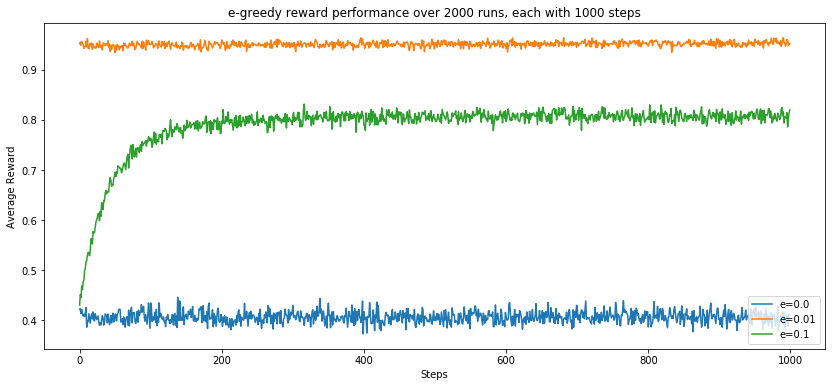

In [0]:
f, ax = plt.subplots(nrows=1, ncols=1,figsize=(14, 6))
for epsilon in Epsilons:
    ax.plot(range(steps), rewards_avg_by_epsilon[epsilon], label='e={}'.format(epsilon))
ax.legend(loc='lower right')
plt.title('e-greedy reward performance over {}'.format(runs) +' runs, each with {}'.format(steps) + ' steps')
plt.xlabel('Steps')
plt.ylabel('Average Reward')

(0, 1)

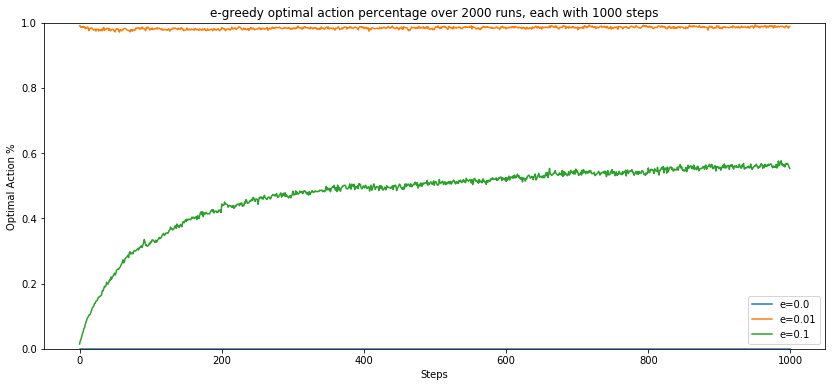

In [0]:
f, ax = plt.subplots(figsize=(14, 6))
for epsilon in Epsilons:
    ax.plot(range(steps), optimal_action_perc_by_epsilon[epsilon], label='e={}'.format(epsilon))
ax.legend()
plt.title('e-greedy optimal action percentage over {}'.format(runs) +' runs, each with {}'.format(steps) + ' steps')
plt.xlabel('Steps')
plt.ylabel('Optimal Action %')
ax.set_ylim(0,1) #Max for 100%